In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [2]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.2, 0.5, size=1000)
y = np.random.uniform(0.1, 0.4, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [3]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

(1000, 5)

In [11]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,1.489991,1,0.349518,0.275152
1,1.990014,1,0.280495,0.334279
2,1.526992,-1,0.440696,0.196653
3,2.703023,1,0.475688,0.222520
4,5.723804,1,0.324074,0.277754
...,...,...,...,...
995,1.770003,1,0.474537,0.151320
996,1.736002,1,0.316638,0.310605
997,3.759946,1,0.229057,0.244817
998,0.738000,1,0.440524,0.149123


- v is parent
- x is a feature from the dataset_reg_v
- y is a feature from the dataset_reg_v

In [12]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x + y
	Link: identity
	bounds: (-3.0, 3.0)
	Intercept ~ Uniform(lower: 0.0, upper: 0.5)
	x ~ Uniform(lower: 0.0, upper: 1.0)
	y ~ Uniform(lower: 0.0, upper: 1.0)
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

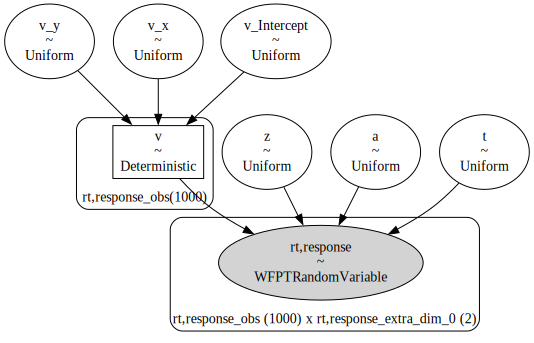

In [13]:
model_reg_v.graph()

In [18]:
trace_reg_v = model_reg_v.sample(cores=2, chains=2, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, z, t, v_Intercept, v_x, v_y]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'v_x'}>, <Axes: title={'center': 'v_x'}>],
       [<Axes: title={'center': 'v_y'}>, <Axes: title={'center': 'v_y'}>]],
      dtype=object)

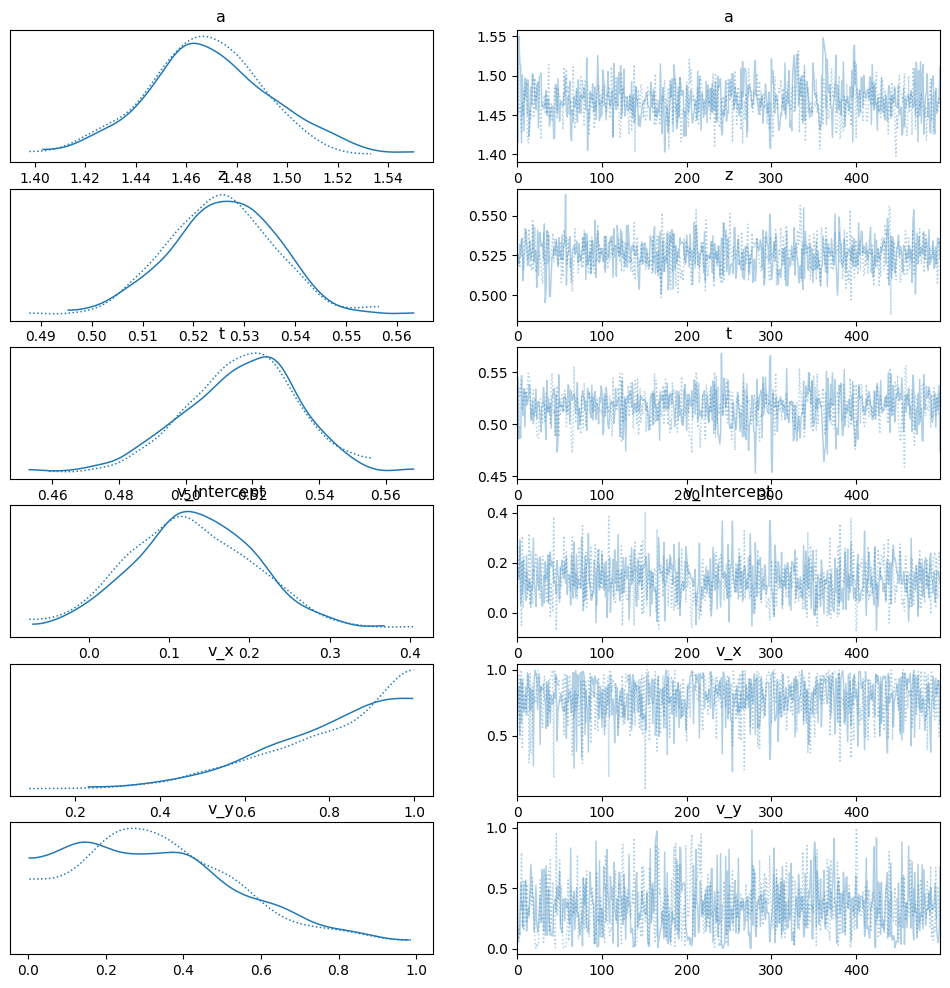

In [19]:
az.plot_trace(model_reg_v.traces)

In [ ]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

In [21]:
new_data = pd.DataFrame(
    {
        "x": np.random.uniform(0.2, 0.5, size=1000),
        "y": np.random.uniform(0.1, 0.4, size=1000),
    }
)

In [ ]:
posterior = model_reg_v.model.predict(model_reg_v.traces, data=new_data, inplace=False)

In [ ]:
posterior

In [ ]:
az.plot_trace(posterior)

In [22]:
posterior = model_reg_v.model.predict(
    model_reg_v.traces, data=new_data, inplace=False, kind="pps"
)

TypeError: rng_fn() missing 1 required keyword-only argument: 'size'
Apply node that caused the error: WFPT_RV_rv{0, (0, 0, 0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2C83F9D60>), TensorConstant{[]}, TensorConstant{10}, TensorConstant{[[[0.52033..437416 ]]]}, TensorConstant{[[[1.49841..4604905]]]}, TensorConstant{[[[0.52430..326784 ]]]}, TensorConstant{[[[0.51691..3142494]]]})
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, (0,)), TensorType(int64, ()), TensorType(float32, (2, 500, 1000)), TensorType(float32, (2, 500, 1)), TensorType(float32, (2, 500, 1)), TensorType(float32, (2, 500, 1))]
Inputs shapes: ['No shapes', (0,), (), (2, 500, 1000), (2, 500, 1), (2, 500, 1), (2, 500, 1)]
Inputs strides: ['No strides', (0,), (), (2000, 4, 4000), (2000, 4, 4), (2000, 4, 4), (2000, 4, 4)]
Inputs values: [Generator(PCG64) at 0x2C83F9D60, array([], dtype=int64), array(10), 'not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
model_reg_v.traces.posterior

In [ ]:
def test_function(arg1, *, arg2):
    return arg1 + arg2

In [ ]:
test_function(1)

In [ ]:
# simulator always expects a list or matrix

# preprocessing in simulator wrapper
# take care of special cases --> concatenate into matrix

# postprocessing in ...
# (chains, trial_output_dim, n_mcmc_samples, n_data)

In [ ]:
# Logic of output

# Definition single sample from posterior predictive (n_samples)

# where do the parameters come from --> Uniform sample from the trace!

# (n_chains, )
# a single posterior predictive sample has the same dimension as our data
# and is a simulated version of our dataset when fixing parameters of our model
# according to a single uniform draw from our posterior (that is already collected from the .sample() call)

#

# n samples form posterior predictive is NOT NECESSARILY == n_mcmc samples (which live in parameter space)